#### Tech Challenge - Fase 2 - Machine Learning and Time Series

#### O problema 

Desenvolver um modelo preditivo capaz de prever se o índice IBOVESPA vai fechar em alta ou baixa no dia seguinte, com base em dados históricos do próprio índice

#### Fonte de dados 

Dados históricos do índice IBOVESPA disponíveis publicamente no link https://br.investing.com/indices/bovespa-historical-data e importando para o seguinte repositorio do Github https://github.com/RicardViana/fiap-Machine-Learning-and-Time-Series/blob/main/Dados%20Hist%C3%B3ricos%20Ibovespa.csv

#### Dicionário de dados


| Nome da Coluna | Descrição | Tipo de Dado |
| :--- | :--- | :--- |
| `Data` | A data da observação, no formato "DD/MM/AAAA". | Texto (object) |
| `Ultimo` | O preço de fechamento do Ibovespa no dia. | Numérico (float64) |
| `Abertura` | O preço de abertura do Ibovespa no dia. | Numérico (float64) |
| `Maxima` | O preço máximo atingido pelo Ibovespa no dia. | Numérico (float64) |
| `Minima` | O preço mínimo atingido pelo Ibovespa no dia. | Numérico (float64) |
| `Volume` | O volume de negociações do dia. Os valores são representados em texto com sufixos (ex: "B" para bilhões, "M" para milhões). | Texto (object) |
| `Variacao` | A variação percentual do Ibovespa no dia. | Texto (object) |

#### Objetivo

Criar um modelo que preveja se o fechamento do IBOVESPA do dia seguinte será maior ou menor que o do dia atual, ou seja:

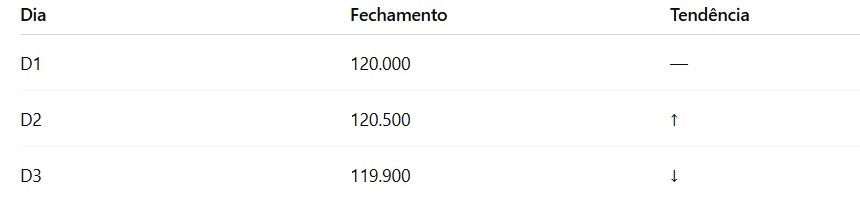

Onde deve prever a tendência (↑ ou ↓) com acuracidade mínima de 75% em um conjunto de teste, esse que contera o último mês (30 dias) de dados disponíveis

#### Desenvolvimento

##### Importação de bibliotecas e pacotes

In [94]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf

##### Criação de funções (DEF)

##### Análise Exploratória de Dados (EDA)

In [95]:
"""

Com sugestão do colega da pós Tiago Turra existe uma biblioteca chamada yfinance (https://pypi.org/project/yfinance/) que possi os mesmo dados do site https://br.investing.com/indices/bovespa-historical-data

"""

# Importando os dados via yfinance

dados_yf = yf.download('^BVSP', period="max", interval="1d", auto_adjust=True, multi_level_index=False, progress=False)

print("Primeiros dados")
display(dados_yf.head())

print("\nUltimos dados")
display(dados_yf.tail())

Primeiros dados


,Close,High,Low,Open,Volume
Date,,,,,
1993-04-27,24.500000,25.400000,24.500000,24.799999,0
1993-04-28,24.299999,24.600000,23.700001,24.500000,0
1993-04-29,23.700001,24.799999,23.700001,24.299999,0
1993-04-30,24.100000,24.200001,23.700001,23.700001,0
1993-05-03,24.100000,24.400000,23.799999,24.100000,0



Ultimos dados


,Close,High,Low,Open,Volume
Date,,,,,
2025-07-14,135299.0,136187.0,134840.0,136187.0,7325600
2025-07-15,135250.0,136022.0,134380.0,135298.0,6904200
2025-07-16,135511.0,135641.0,134265.0,135250.0,7833200
2025-07-17,135565.0,135793.0,135016.0,135515.0,6800000
2025-07-18,133382.0,135563.0,133296.0,135563.0,10071800


In [96]:
# Importar os dados via github 
# Necessario o uso do arumento thousands e decimal para não ter problema com o data frame --> o . na fonte é para separar o milhar

link = r"https://raw.githubusercontent.com/RicardViana/fiap-Machine-Learning-and-Time-Series/refs/heads/main/Dados%20Hist%C3%B3ricos%20Ibovespa.csv"
dados_origem = pd.read_csv(link, sep= ";", thousands='.', decimal=',', index_col="Data")

In [97]:
# Verificando os dados via .head

dados_origem.head()

,Ultimo,Abertura,Maxima,Minima,Volume,Variacao
Data,,,,,,
02/01/1995,4301,4354,4398,4300,"4,10B","-1,22%"
03/01/1995,4098,4370,4386,4094,"8,35B","-4,72%"
04/01/1995,3968,4098,4098,3861,"11,95B","-3,17%"
05/01/1995,4037,3968,4040,3944,"8,76B","1,74%"
06/01/1995,3827,4037,4106,3813,"12,02B","-5,20%"


In [98]:
# Verificando os dados via .tail

dados_origem.tail()

,Ultimo,Abertura,Maxima,Minima,Volume,Variacao
Data,,,,,,
30/06/2025,138855,136865,139103,136430,"7,68B","1,45%"
01/07/2025,139549,138855,139695,138855,"6,35B","0,50%"
02/07/2025,139051,139586,140049,138384,"8,81B","-0,36%"
03/07/2025,140928,139051,141304,139051,"6,08B","1,35%"
04/07/2025,141264,140928,141564,140597,"3,31B","0,24%"


In [99]:
# Ajustar o formato da coluna Data 

dados_origem.index = pd.to_datetime(dados_origem.index, format = "%d/%m/%Y")

In [100]:
# Verificand os dados os dados do data frame dados_origem com o dados_yf --> Verificar se há diferença 

print("Dados do data frame dados_origem")
display(dados_origem[['Ultimo', 'Abertura', 'Maxima', 'Minima']].tail())

print("\nDados do data frame dados_yf")
display(dados_yf[['Close', 'Open', 'High', 'Low']].query("Date >= '2025-06-30 00:00:00' and Date <= '2025-07-04 00:00:00'"))


Dados do data frame dados_origem


,Ultimo,Abertura,Maxima,Minima
Data,,,,
2025-06-30,138855,136865,139103,136430
2025-07-01,139549,138855,139695,138855
2025-07-02,139051,139586,140049,138384
2025-07-03,140928,139051,141304,139051
2025-07-04,141264,140928,141564,140597



Dados do data frame dados_yf


,Close,Open,High,Low
Date,,,,
2025-06-30,138855.0,136865.0,139103.0,136430.0
2025-07-01,139549.0,138855.0,139695.0,138855.0
2025-07-02,139051.0,139586.0,140049.0,138384.0
2025-07-03,140928.0,139051.0,141304.0,139051.0
2025-07-04,141478.0,140928.0,141537.0,140597.0


In [101]:
# Veficiando os dados dados do data frame 

dados_origem.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7555 entries, 1995-01-02 to 2025-07-04
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Ultimo    7555 non-null   int64 
 1   Abertura  7555 non-null   int64 
 2   Maxima    7555 non-null   int64 
 3   Minima    7555 non-null   int64 
 4   Volume    7554 non-null   object
 5   Variacao  7555 non-null   object
dtypes: int64(4), object(2)
memory usage: 413.2+ KB


In [104]:
# Verificando os dados nulos
dados_origem.isnull().sum()

Ultimo      0
Abertura    0
Maxima      0
Minima      0
Volume      1
Variacao    0
dtype: int64

In [ ]:
# Verificando os registros que estão nulos 
# Como para o nosso projeto esse campo Volume não é util, vamos manter esse registro
dados_origem[dados_origem.isnull().any(axis=1)]

,Ultimo,Abertura,Maxima,Minima,Volume,Variacao
Data,,,,,,
2016-02-10,40377,40592,40592,39960,NaN,"-0,53%"
